In [364]:
# read mat file
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from queue import Queue
import cv2 as cv
import copy
import time
import dlib
from scipy import signal

## 1. Take one data as an example

In [365]:
# load mat file
sample_file = sio.loadmat('p6_4.mat')
print(sample_file.keys())

dict_keys(['__header__', '__version__', '__globals__', 'video', 'GT_ppg', 'light', 'motion', 'exercise', 'skin_color', 'gender', 'glasser', 'hair_cover', 'makeup'])


You can see there are several keys in the data. You will mainly use 'video' and 'GT_ppg' for your evaluation. The 'video' records the stationary scene of the face, and the 'GT_ppg' records the ground truth heart rate of the participants in the video.

In [366]:
video = sample_file['video']
gt = sample_file['GT_ppg']
video.shape, gt.shape

((1800, 80, 60, 3), (1, 1800))

In [367]:
with np.printoptions(threshold=np.inf):
    print(gt)

[[ 68.          71.25917686  70.77753059  20.88502741  59.36622273
   97.84741805 114.81423804 249.44271413 246.14682981 188.66629588
  118.36707453  67.92547275  80.          87.          87.
   86.4962551   86.          83.98020022  82.73804227  81.53081201
   80.          78.01475714  77.          76.56536893  75.63876529
   74.05283648  72.3507601   90.2017056  172.48980349 219.24731183
  194.04271413 148.7862069  124.63915462 125.44471635 129.87271572
  119.44862347 113.55565443 118.56069707 120.98991472 114.85131628
  104.27341491  93.50410178  87.06324488  82.80482017  81.
   80.          79.13073786  78.83937709  77.61468298  76.
   74.16529477  72.93635786  71.69561417  70.          69.
   69.          68.68379681  67.98379151  66.7655914   67.980571
  115.67408231 200.42157953 204.42068966 165.94867313 127.19577308
  116.81023359 123.8894327  119.72747497 109.         112.11167964
  117.         114.22677049 105.77678902  94.84570157  86.87860586
   82.26369577  79.98991472  

As mentioned in the paper, the sampling rate of the video and ground truth is **30 fps**.

## 2. Evaluation

In [368]:
import os

# Define the directory path
dir_path = '/Users/zihan/Documents/hku/aiot/group proj/mmpd'

# Loop over all files in the directory
for filename in os.listdir(dir_path):
    # Check if the file is a regular file (not a directory)
    if os.path.isfile(os.path.join(dir_path, filename)):
        # Do something with the file
        print(filename)

.DS_Store
p29_0.mat
p29_4.mat
p6_8.mat
p6_4.mat
p29_8.mat
p6_0.mat
p29_16.mat
test.ipynb
p6_16.mat


You need to evaluate the performance of your algorithm on the above eight videos. The evaluation metric is the **mean absolute error (MAE)** between the estimated heart rate and the ground truth. The MAE is calculated as follows:
$$
MAE = \frac{1}{N}\sum_{i=1}^{N}|HR_{est}^{(i)} - HR_{gt}^{(i)}|
$$
You can use MAE as your evaluation metric in your report. Other metrics are also welcomed.

In [369]:
video.shape

(1800, 80, 60, 3)

In [370]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(r"/Users/zihan/Documents/hku/aiot/group proj/rPPG-project/code/model/shape_predictor_81_face_landmarks.dat")  
 

In [371]:
MIN_HZ = 0.85  # 51bpm
MAX_HZ = 2.5 # 150bpm
BETA = 0.95 # smoothing factor



In [372]:
# %pip uninstall -y obspy
# %pip install obspy

In [373]:
# %pip uninstall -y lxml
# %pip install lxml

In [374]:
from obspy.signal.detrend import polynomial

def Signal_Preprocessing(rgbsig):
        data = np.array(rgbsig)
        data_r = polynomial(data[:, 0], order=2)
        data_g = polynomial(data[:, 1], order=2)
        data_b = polynomial(data[:, 2], order=2)
        return np.array([data_r, data_g, data_b]).T

def Signal_Preprocessing_single(sig):
        return polynomial(sig, order=2)

def transfer2bmp(beta, _bpm, spec, fps):
        return beta * _bpm + (1 - beta) * np.argmax(spec[:int(len(spec)/2)])/len(spec) * fps * 60



In [375]:
# %pip install --upgrade lxml

In [376]:
def marker(frame):
        frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        faces = detector(frame_gray)
        if len(faces) == 1:
            face = faces[0]
            landmarks = [[p.x, p.y] for p in predictor(frame_gray, face).parts()]
        try:
            return landmarks
        except:
            return None
        
def roi(frame, flag_face):
    frame = cv.GaussianBlur(frame, (5, 5), 0)
    landmark = marker(frame)
    cheek_l = [1, 2, 3, 4, 48, 31, 28, 39]
    cheek_r = [15, 14, 14, 12, 54, 35, 28, 42]
    forehead = [69, 70, 71, 80, 72, 25, 24, 23, 22, 21, 20, 19, 18]

    mask_l = np.zeros(frame.shape, dtype=np.uint8)
    mask_r = np.zeros(frame.shape, dtype=np.uint8)
    mask_f = np.zeros(frame.shape, dtype=np.uint8)
    mask_display = np.zeros(frame.shape, dtype=np.uint8)
    try:
        flag_face = True
        pts_l = np.array(
            [landmark[i] for i in cheek_l], np.int32).reshape((-1, 1, 2))
        pts_r = np.array(
            [landmark[i] for i in cheek_r], np.int32).reshape((-1, 1, 2))
        pts_f = np.array(
            [landmark[i] for i in forehead], np.int32).reshape((-1, 1, 2))
        
        mask_l = cv.fillPoly(mask_l, [pts_l], (255, 255, 255))
        mask_r = cv.fillPoly(mask_r, [pts_r], (255, 255, 255))
        mask_f = cv.fillPoly(mask_f, [pts_f], (255, 255, 255))

        kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (15, 30))
        mask_l = cv.erode(mask_l, kernel, iterations=1)
        mask_r = cv.erode(mask_r, kernel, iterations=1)
        mask_f = cv.erode(mask_f, kernel, iterations=1)
        
        mask_display_l, mask_display_r, mask_display_f = copy.copy(mask_l), copy.copy(mask_r), copy.copy(mask_f)
        mask_display_l[:, :, 1] = 0
        mask_display_r[:, :, 0] = 0
        mask_display_f[:, :, 2] = 0

        mask_display = cv.bitwise_or(mask_display_l, mask_display_r)
        mask_display = cv.bitwise_or(mask_display, mask_display_f)
        face_mask = cv.addWeighted(mask_display, 0.25, frame, 1, 0)

        roi_l = cv.bitwise_and(mask_l, frame)
        roi_r = cv.bitwise_and(mask_r, frame)
        roi_f = cv.bitwise_and(mask_f, frame)

        return roi_l, roi_r, roi_f, flag_face, face_mask
    
    except Exception as e:
        face_mask = frame
        flag_face = False
        return None, None, None, flag_face, face_mask

In [377]:
def RGB_hist(roi):
    b_hist = cv.calcHist([roi], [0], None, [256], [0, 256])
    g_hist = cv.calcHist([roi], [1], None, [256], [0, 256])
    r_hist = cv.calcHist([roi], [2], None, [256], [0, 256])

    b_hist = np.reshape(b_hist, (256))
    g_hist = np.reshape(g_hist, (256))
    r_hist = np.reshape(r_hist, (256))

    b_hist[0] = 0
    g_hist[0] = 0
    r_hist[0] = 0

    r_hist = r_hist/np.sum(r_hist)
    g_hist = g_hist/np.sum(g_hist)
    b_hist = b_hist/np.sum(b_hist)

    return [r_hist, g_hist, b_hist]

def Hist2Feature(hist):
    hist_r = hist[0]
    hist_g = hist[1]
    hist_b = hist[2]

    hist_r /= np.sum(hist_r)
    hist_g /= np.sum(hist_g)
    hist_b /= np.sum(hist_b)

    dens = np.arange(0, 256, 1)
    mean_r = dens.dot(hist_r)
    mean_g = dens.dot(hist_g)
    mean_b = dens.dot(hist_b)

    return [mean_r, mean_g, mean_b]


In [378]:
def CHROM(signal):
    X = signal
    Xcomp = 3*X[:, 0] - 2*X[:, 1]
    Ycomp = (1.5*X[:, 0])+X[:, 1]-(1.5*X[:, 2])
    sX = np.std(Xcomp)
    sY = np.std(Ycomp)
    alpha = sX/sY
    bvp = Xcomp - alpha * Ycomp
    return bvp

def butterworth_filter(data, low, high, sample_rate, order=5):
    nyquist_rate = sample_rate * 0.5
    low /= nyquist_rate
    high /= nyquist_rate
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.lfilter(b, a, data)

In [379]:
def cal_bpm(flag_queue, Sig_f, Sig_l, Sig_r, fps, bpm_avg, bpm_f, bpm_l, bpm_r):
    Sig_f = np.array(Sig_f)
    Sig_l = np.array(Sig_l)
    Sig_r = np.array(Sig_r)
    if flag_queue:
        if Sig_f.size != 1:
            bvp_f_raw = CHROM(Sig_f)
            conf_f = 1 / \
                (max(bvp_f_raw) - min(bvp_f_raw))
            bvp_f = butterworth_filter(Signal_Preprocessing_single(bvp_f_raw), MIN_HZ, MAX_HZ, fps, order=5)
            spc_f = np.abs(np.fft.fft(bvp_f))
            bpm_f = transfer2bmp(BETA, bpm_f, spc_f, fps)
        if Sig_l.size != 1:
            bvp_l_raw = CHROM(Sig_l)
            conf_l = 1 / \
                (max(bvp_l_raw)-min(bvp_l_raw))
            bvp_l = butterworth_filter(Signal_Preprocessing_single(bvp_l_raw), MIN_HZ, MAX_HZ, fps, order=5)
            spc_l = np.abs(np.fft.fft(bvp_l))
            bpm_l = transfer2bmp(BETA, bpm_l, spc_l, fps)
        if Sig_r.size != 1:
            bvp_r_raw = CHROM(Sig_r)
            conf_r = 1 / \
                (max(bvp_r_raw)-min(bvp_r_raw))
            bvp_r = butterworth_filter(Signal_Preprocessing_single(bvp_r_raw), MIN_HZ, MAX_HZ, fps, order=5)
            spc_r = np.abs(np.fft.fft(bvp_r))
            bpm_r = transfer2bmp(BETA, bpm_r, spc_r, fps)
            
        total_conf = conf_f+conf_l+conf_r
        conf_f = conf_f/total_conf
        conf_l = conf_l/total_conf
        conf_r = conf_r/total_conf
        bpm_avg = bpm_f*conf_f+bpm_l * conf_l+bpm_r*conf_r

    return bpm_avg, bpm_f, bpm_l, bpm_r
    

In [ ]:
name_list = ['p6_0.mat', 'p6_4.mat', 'p6_8.mat', 'p6_16.mat', 'p29_0.mat', 'p29_4.mat', 'p29_8.mat', 'p29_16.mat']
predictions_dict = {}

for name in name_list:
    sample_file = sio.loadmat('p6_4.mat')
    video = sample_file['video']

    fps = 30
    QUEUE_MAX = 256
    QUEUE_WINDOWS = 32
    Queue_rawframe = Queue(maxsize=3)

    Queue_Sig_l = Queue(maxsize=QUEUE_MAX)
    Queue_Sig_r = Queue(maxsize=QUEUE_MAX)
    Queue_Sig_f = Queue(maxsize=QUEUE_MAX)
    Queue_Time = Queue(maxsize=QUEUE_WINDOWS)

    flag_face, flag_queue = False, False  
    Sig_l = None
    Sig_r = None
    Sig_f = None

    face_mask = None
    frame_display = None

    bpm_f = 60
    bpm_l = 60
    bpm_r = 60
    bpm_avg = 60

    predictions = []

    for frame in video:
        up_width = 1080
        up_height = 1920
        up_points = (up_width, up_height)
        frame = cv.resize(frame, up_points, interpolation= cv.INTER_LINEAR)
        frame *= 255
        frame = frame.astype('uint8') 

        frame_display = copy.copy(frame)
        if Queue_Time.full():
            Queue_Time.get_nowait()
        if Queue_rawframe.full():
                    Queue_rawframe.get_nowait()
        else:
            Queue_Time.put_nowait(time.time())
            
        try:
            Queue_rawframe.put_nowait(frame)
        except Exception as e:
            pass
        
        roi_l, roi_r, roi_f, flag_face, face_mask = roi(frame, flag_face)
        # print(roi_l)
        if roi_l is not None and roi_r is not None and roi_f is not None:
            hist_l = RGB_hist(roi_l)
            hist_r = RGB_hist(roi_r)
            hist_f = RGB_hist(roi_f)
            if Queue_Sig_l.full():
                Sig_l = copy.copy(list(Queue_Sig_l.queue))
                Queue_Sig_l.get_nowait()
            else:
                flag_queue = False

            if Queue_Sig_r.full():
                Sig_r = copy.copy(list(Queue_Sig_r.queue))
                Queue_Sig_r.get_nowait()
            else:
                flag_queue = False
        
            if Queue_Sig_f.full():
                Sig_f = copy.copy(list(Queue_Sig_f.queue))
                Queue_Sig_f.get_nowait()
                flag_queue = True
            else:
                flag_queue = False

            Queue_Sig_l.put_nowait(Hist2Feature(hist_l))
            Queue_Sig_r.put_nowait(Hist2Feature(hist_r))
            Queue_Sig_f.put_nowait(Hist2Feature(hist_f))
        
        else:
            hist_l, hist_r, hist_f = None, None, None
            Queue_Sig_l.queue.clear()
            Queue_Sig_r.queue.clear()
            Queue_Sig_f.queue.clear()

        print(Queue_Sig_f.qsize())

        bpm_avg, bpm_f, bpm_l, bpm_r = cal_bpm(flag_queue, Sig_f, Sig_l, Sig_r, fps, bpm_avg, bpm_f, bpm_l, bpm_r)
        predictions.append(bpm_avg)

    predictions_dict[name] = predictions  


In [ ]:
with np.printoptions(threshold=np.inf):
    print(gt)

In [382]:
for name in name_list:
    sample_file = sio.loadmat(name)
    gt = sample_file['GT_ppg']
    N = gt.shape[1]
    gt_value = gt[0]
    prediction = predictions_dict[name]
    # print(gt_value.shape)
    # print(len(prediction))
    MAE = 0
    for i in range(N):
        sig_gt = gt_value[i]
        sig_pred = prediction[i]
        MAE += abs(sig_pred - sig_gt)
    MAE /= N
    print(f'MAE of File {name}: {MAE}')

MAE of File p6_0.mat: 38.716036534555215
MAE of File p6_4.mat: 35.045216774740126
MAE of File p6_8.mat: 40.234542000691754
MAE of File p6_16.mat: 38.66299749140089
MAE of File p29_0.mat: 33.47884126172238
MAE of File p29_4.mat: 35.24166680057325
MAE of File p29_8.mat: 28.916818006226563
MAE of File p29_16.mat: 29.93042722805038


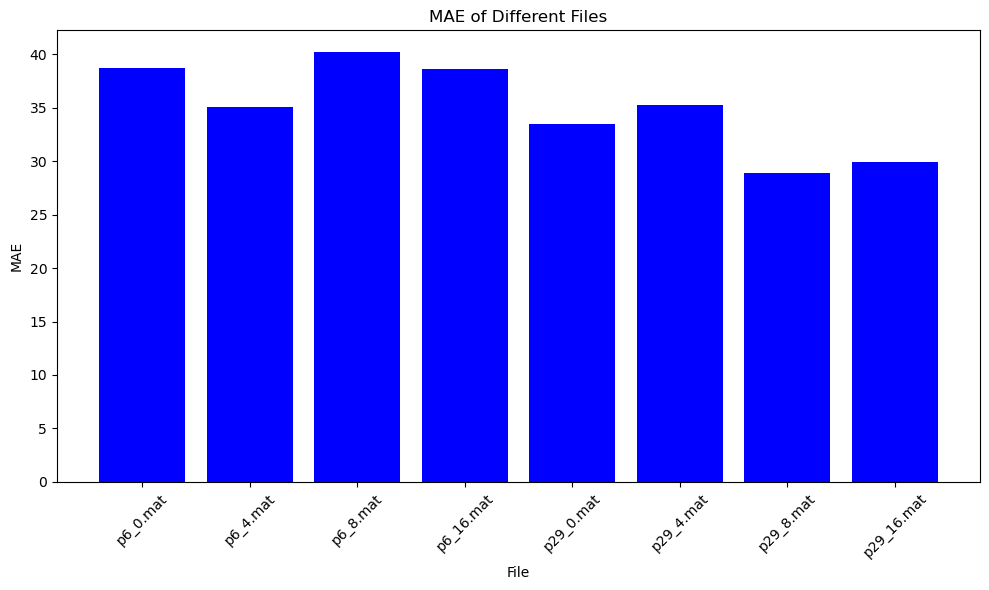

In [384]:
import matplotlib.pyplot as plt

# 数据
files = ['p6_0.mat', 'p6_4.mat', 'p6_8.mat', 'p6_16.mat', 'p29_0.mat', 'p29_4.mat', 'p29_8.mat', 'p29_16.mat']
maes = [38.716036534555215, 35.045216774740126, 40.234542000691754, 38.66299749140089, 33.47884126172238, 35.24166680057325, 28.916818006226563, 29.93042722805038]

# 创建图像
plt.figure(figsize=(10, 6))

# 绘制条形图
plt.bar(files, maes, color='blue')

# 添加标题和轴标签
plt.title('MAE of Different Files')
plt.xlabel('File')
plt.ylabel('MAE')

# 旋转x轴标签，使其更易读
plt.xticks(rotation=45)

# 显示图像
plt.tight_layout()
plt.show()